In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import pandas as pd
import glob
import re
# Statistics
from scipy.stats import norm
from scipy.special import factorial
# Parallel
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

In [2]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [3]:
Data = []
Mass = np.array([])

for f in glob.glob('Data/*.csv'):
    #print(f)
    
    data = pd.read_csv(f,sep=',')
    Data.append(data)

    # Extraer los últimos tres números del nombre del archivo
    match = re.search(r'(\d{3})\.csv$', f)
    if match:
        Mass = np.append(Mass, float(match.group(1)))

# Emparejar los numeros con los dataframes
paired = list(zip(Mass,Data))

# Ordenar los pares segun las masas
Mass_sorted = sorted(paired, key=lambda x: x[0])

# Separar de nuevo los numeros y los dataFrames
Mass_sorted, Data = zip(*Mass_sorted)

# Numpy array
Mass = np.array(Mass_sorted)

print(Mass)

[100. 106. 112. 118. 124. 130. 136. 142. 148. 154. 160.]


In [4]:
# Estimator definition
def GetLnQ(n,b,s,mu):
    return 2*(mu*s - n*np.log( 1 + (mu*s/b) ))

In [5]:
def GetJointLnQ(LnQ,mu,Null=True):

    Q = 0.

    for c in range(N):

        if Null:
            ntoy = np.random.poisson(b[c])
        else:
            ntoy = np.random.poisson( mu*s[c] + b[c] )

        Q += LnQ(ntoy,b[c],s[c],mu)

    return Q

In [6]:
def GetObsJointLnQ(LnQ,mu,Expected = True):

    Q = 0.
    
    for c in range(N):

        if Expected: # Observed events are the expected background
            Q += LnQ( b[c], b[c], s[c], mu )
        else:
            Q += LnQ( n[c], b[c], s[c], mu )

    return Q

In [10]:
def Sampler(mu, Ntoys = int(1e3)):

    q0 = np.zeros(Ntoys)
    q1 = np.zeros(Ntoys)

    for i in range(Ntoys):
        q0[i] = GetJointLnQ(GetLnQ, mu)  #H0
        q1[i] = GetJointLnQ(GetLnQ, mu, Null = False) #H1
    
    return q0,q1

In [11]:
def GetPValue(data,Qobs, Null = True):

    if Null:
        count_below_threshold = np.sum( data <= Qobs )
        p_value = count_below_threshold/data.shape[0]

    else:
        count_above_threshold = np.sum( data >= Qobs )
        p_value = count_above_threshold / data.shape[0]

    return p_value

In [12]:
# Funcion en paralelo
def GetCls_for_mu(i, mu, Expected = False):

    Qobs = GetObsJointLnQ(GetLnQ,mu,Expected)
    q0,q1 = Sampler(mu)
    
    p0 = GetPValue(q0, Qobs, Null = True)
    p1 = GetPValue(q1, Qobs, Null = False)

    Clb = 1 - p0
    Clsb = p1

    Cls = Clsb/Clb

    return i,Clsb

In [13]:
def GetCls_parallel(mu, Expected=False, num_processors=None):

    p_value = np.zeros_like(mu)

    with ProcessPoolExecutor(max_workers=num_processors) as executor:

        futures = []

        # Crear las tareas (futuras) para cada valor de mu
        for i in range(mu.shape[0]):

            futures.append(executor.submit(GetCls_for_mu, i, mu[i], Expected))

        # Recolectar los resultados a medida que se completan
        for future in tqdm(as_completed(futures), total=len(futures)):
            i, Clsb = future.result()
            p_value[i] = Clsb

    return p_value

In [14]:
# Upper limit
def GetUpperLimit(mu,Cls,alpha = 0.05):

    i = np.where( Cls <= alpha )

    if len(i[0]) == 0:
        print('--- Cls is never less than alpha --- ')
        return 0.
    else:
        i = i[0][0]

    # Saving the indez where pvalues is less than the critical value

    x0 = mu[i-1]
    x1 = mu[i]
    fx0 = Cls[i-1]
    fx1 = Cls[i]

    # Compute the slope
    m = (fx1-fx0)/(x1-x0)

    if m == 0:
        print('--- Problem with the scan ---')
        return 0.

    # 1D Polynomial interpolation
    mup = (alpha - fx0)/m + x0

    return mup

In [15]:
# Running the upper limits for each signal points

for data in Data:

    labels = list(data.keys())
    n = np.array(data[labels[0]])
    b = np.array(data[labels[1]])
    s = np.array(data[labels[2]])
    N = n.shape[0]

    # SetPOI scan
    mu = np.linspace(0.1,2,10)
    Op_value = GetCls_parallel(mu,Expected=False,num_processors=8)
    Ep_value = GetCls_parallel(mu,Expected=True,num_processors=8)

    ExpectedLimit = GetUpperLimit(mu,Ep_value)
    ObservedLimit = GetUpperLimit(mu,Op_value)

    print(ExpectedLimit,ObservedLimit)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.07it/s]

0.7105982905982906 0.5120481927710844



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.67it/s]

0.46895119418483905 0.3248792270531401



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.63it/s]

0.48286252354048964 0.4908172635445363



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.85it/s]


0.43174603174603177 1.1323333333333334


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.02it/s]

0.3770833333333333 1.362984496124031



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.62it/s]

0.3314102564102564 0.8701646090534979



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.02it/s]


0.3030225627926777 0.3251851851851852


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.43it/s]

0.2940707523667165 0.23730803974706416



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.98it/s]


0.28369408369408367 0.3992967651195499


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.61it/s]

0.2751370204285003 0.4257142857142857



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.29it/s]

0.34503968253968254 0.40875


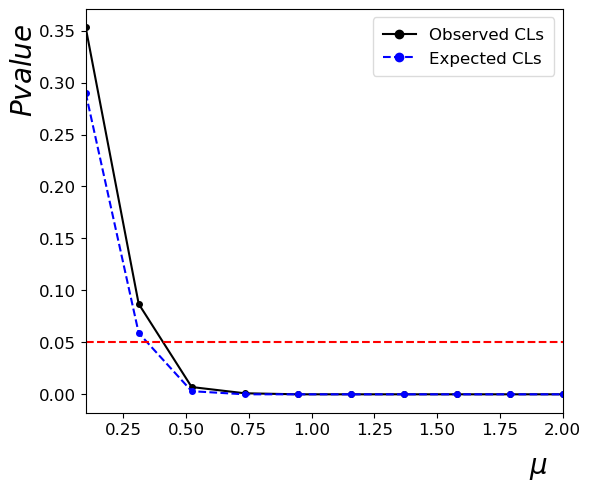

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(mu,Op_value,color='k',marker='o',label='Observed CLs')
ax.plot(mu,Ep_value,'--',color='b',marker='o',label='Expected CLs')

ax.axhline(y=0.05,ls='--',color='r')

# Label X
ax.set_xlabel(r'$\mu$')
ax.xaxis.set_label_coords(0.95,-0.1)
ax.set_xlim(mu[0],mu[-1])

# Label Y
ax.set_ylabel(r'$Pvalue$')
ax.yaxis.set_label_coords(-0.1,0.85)

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')

#
plt.savefig('UpperLimit_Scan.pdf')